In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlalchemy as sa

from scipy.interpolate import griddata
from sqlalchemy import create_engine
from sqlalchemy.engine import URL

# DB Connection
base_connection = "DRIVER={ODBC Driver 17 for SQL Server};SERVER=analityk.wwsi.edu.pl,50221;uid=student;pwd=ciekawski"
air_polution_db = f"{base_connection};DATABASE=Smogoliczka"
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": air_polution_db})
engine = create_engine(connection_url)

# Fetch Map Points
map_points = None
with engine.begin() as conn:
    map_points_query = "SELECT Kontur.ToString() AS Data, Nazwa FROM KonturyWoj ORDER BY KodTeryt;"
    map_points = pd.read_sql_query(sa.text(map_points_query), conn)

# Fetch Air Polution Data
air_polution = None
with engine.begin() as conn:
    air_polution_query = """
        WITH polution_data AS  (
            SELECT
                YEAR(p.Data) AS Year
                ,DATEPART(quarter, p.Data) AS Quarter
                ,AVG(p.dane) AS Value
                ,rp.NazwaParametru AS Parameter
                ,rp.IdParametru AS ParameterId
                ,LOWER(sp.Wojewodztwo) AS Region
            FROM
                Smogoliczka.dbo.Pomiary AS p
            INNER JOIN Smogoliczka.dbo.RodzajeParametrow AS rp
               ON p.IDRodzaju = rp.IdParametru
            INNER JOIN Smogoliczka.dbo.StacjePomiarowe AS sp
               ON p.IDStacji = sp.IdStacji
            GROUP BY
                YEAR(p.Data)
                ,DATEPART(quarter, p.Data)
                ,rp.ParKod
                ,rp.NazwaParametru
                ,rp.IdParametru
                ,LOWER(sp.Wojewodztwo)
        )
        SELECT
            pd.*,
            MAX(n.do) AS MaxNorm
            FROM 
                polution_data AS pd
            INNER JOIN Smogoliczka.dbo.Normy AS n
                ON pd.ParameterId = n.IdParametru
            GROUP BY 
                pd.Year, 
                pd.Quarter, 
                pd.Value, 
                pd.Parameter, 
                pd.ParameterId, 
                pd.Region
            ORDER BY 
                pd.Value DESC;
    """
    air_polution = pd.read_sql_query(sa.text(air_polution_query), conn)

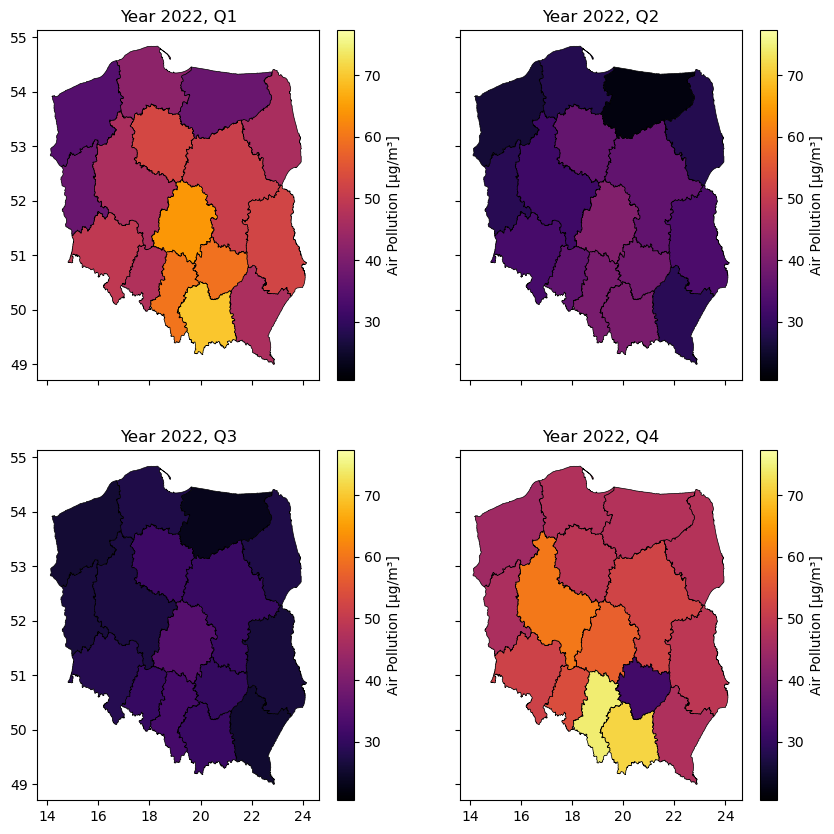

In [2]:
import matplotlib as mpl
from matplotlib.cm import ScalarMappable

# Avg PM Air Polution in each quater 2020
from collections import defaultdict
from matplotlib.colors import Normalize
from shapely.wkt import loads

# Sum Polutions
pm_polution = ["pył zawieszony PM10", "pył zawieszony PM2.5"]
pm_polution_2022 = [x for idx, x in air_polution.iterrows() if x.Year == 2020 and x.Parameter in pm_polution]

# 2020 Year Data
min_polution_10 = min([x["Value"] for x in pm_polution_2022 if x["Parameter"] == pm_polution[0]])
min_polution_25 = min([x["Value"] for x in pm_polution_2022 if x["Parameter"] == pm_polution[1]])
min_polution = min_polution_10 + min_polution_25
max_polution_10 = max([x["Value"] for x in pm_polution_2022 if x["Parameter"] == pm_polution[0]])
max_polution_25 = max([x["Value"] for x in pm_polution_2022 if x["Parameter"] == pm_polution[1]])
max_polution = max_polution_10 + max_polution_25
norm_polution = Normalize(vmin=min_polution, vmax=max_polution)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
cmap = mpl.colormaps['inferno']

for subplot in axes.flat:
    subplot.set(xlabel='', ylabel='')
    subplot.label_outer()

for quarter in range(4):
    # [(q0,q1), (q2, q3)]
    row = 0 if quarter in [0, 1] else 1
    col = 0 if quarter in [0, 2] else 1
    subplot = axes[row, col]
    subplot.set_title("Year 2022, Q{}".format(quarter+1))
    
    for _index, point in map_points.iterrows():
        region = point["Nazwa"]
        geometry = loads(point["Data"])

        quarter_polution = [x for x in pm_polution_2022 if x["Quarter"] == quarter + 1]
        polution_10 = [x for x in quarter_polution if x["Parameter"] == pm_polution[0] and x["Region"] == region]
        polution_25 = [x for x in quarter_polution if x["Parameter"] == pm_polution[1] and x["Region"] == region]
        polution = 0
        for p in polution_10 + polution_25:
            polution += p["Value"]
    
        if geometry.geom_type == 'Polygon':
            x, y = geometry.exterior.xy
            subplot.fill(x, y, color=cmap(norm_polution(polution)), edgecolor='black', linewidth=0.5)
        elif geometry.geom_type == 'MultiPolygon':
            for poly in geometry.geoms:
                x, y = poly.exterior.xy
                subplot.fill(x, y, color=cmap(norm_polution(polution)), edgecolor='black', linewidth=0.5)

    fig.colorbar(ScalarMappable(norm=norm_polution, cmap=cmap), ax=subplot, label="Air Pollution [µg/m³]")

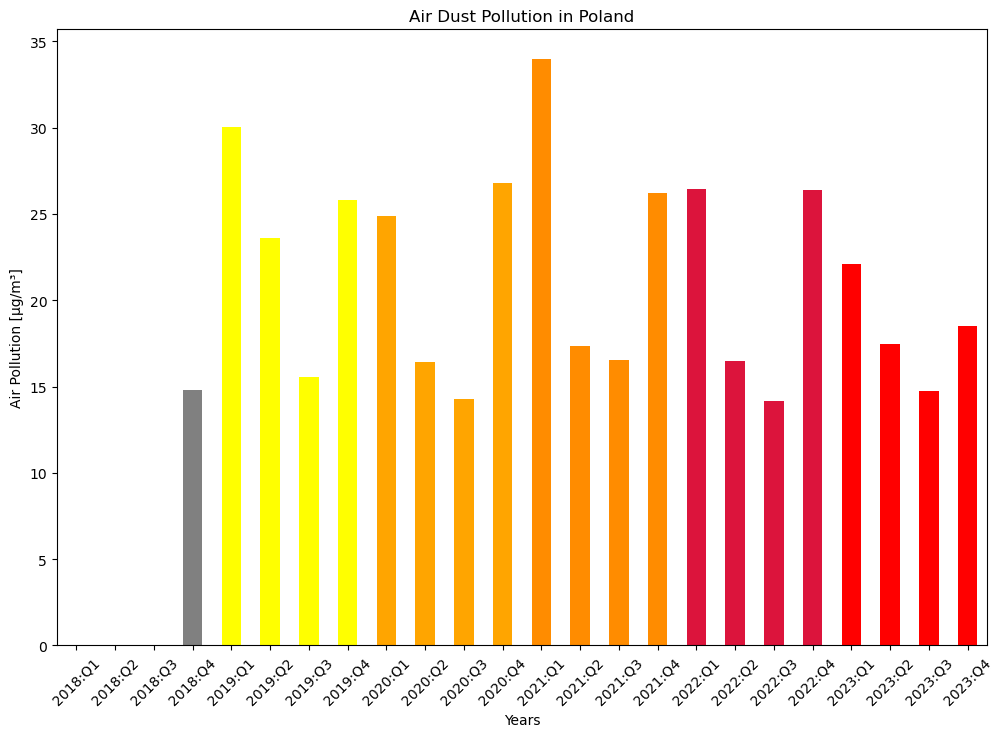

In [7]:
# Avarage Dust Polution In Years
pm_polution = ["pył zawieszony PM10", "pył zawieszony PM2.5"]
quaters = ["Q1", "Q2", "Q3", "Q4"]
pm_polution = [x for idx, x in air_polution.iterrows() if x.Parameter in pm_polution]
pm_polution = pd.DataFrame(data=pm_polution)

# Group by & parse columns
pm_polution = pm_polution.groupby(["Year", "Quarter"])["Value"].mean().reset_index()
pm_polution["Quarter"] = "Q" + pm_polution["Quarter"].astype(str)
pm_polution = pm_polution.pivot_table(index="Year", columns="Quarter", values="Value").reset_index()

# Add Colorts
colors = ["yellow", "orange", "darkorange", "crimson", "red"]
checks = [
    (pm_polution["Year"] == 2019), 
    (pm_polution["Year"] == 2020), 
    (pm_polution["Year"] == 2021), 
    (pm_polution["Year"] == 2022), 
    (pm_polution["Year"] == 2023)
]
pm_polution["Color"] = np.select(checks, colors, default='gray')

# Final Transofmration
quarter_order = {'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4}
pm_polution = pm_polution.melt(id_vars=["Year", "Color"], value_vars=quaters[:], var_name="Quarter", value_name="Value")
pm_polution["QuarterNum"] = pm_polution["Quarter"].map(quarter_order)
pm_polution = pm_polution.sort_values(by=["Year", "QuarterNum"]).drop("QuarterNum", axis=1)
pm_polution["YearQuarter"] = pm_polution["Year"].astype(str) + ":" + pm_polution["Quarter"].astype(str)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
pm_polution.plot(kind="bar", x="YearQuarter", y="Value", ax=ax, color=pm_polution["Color"])

plt.xlabel("Years")
plt.ylabel("Air Pollution [µg/m³]")
plt.title("Air Dust Pollution in Poland")
plt.legend().set_visible(False)
plt.xticks(rotation=45)

plt.show()

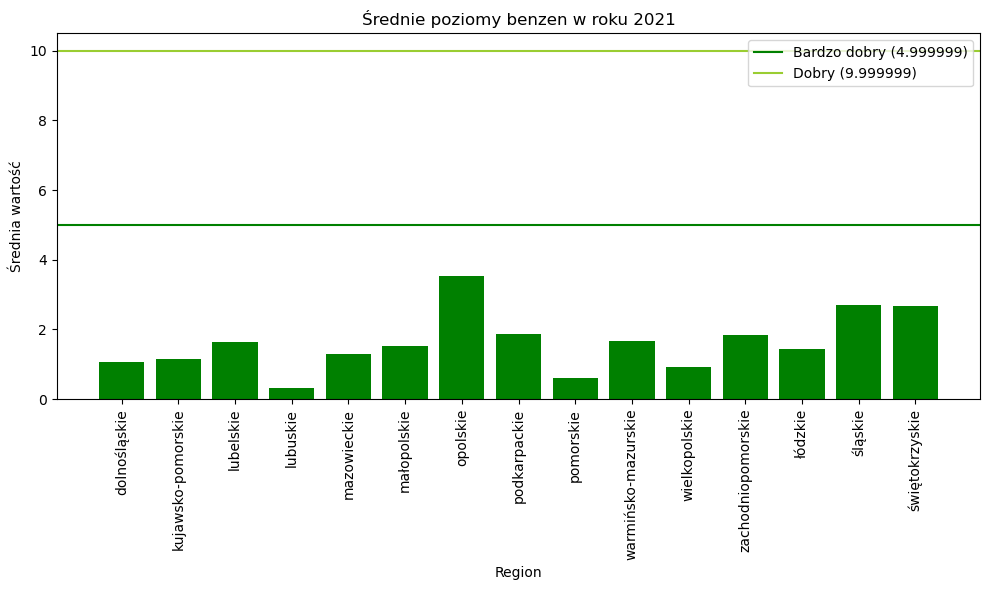

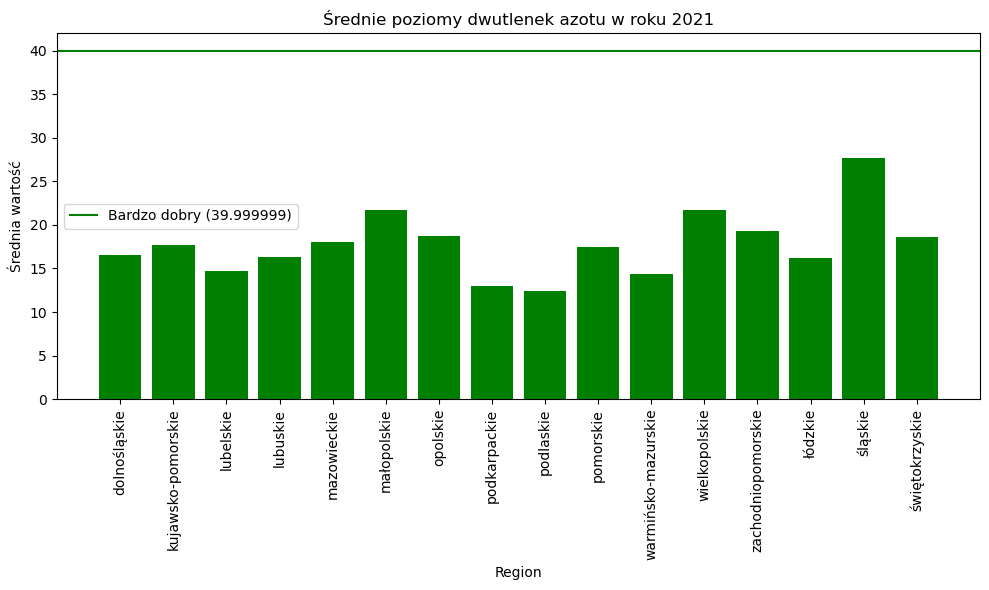

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


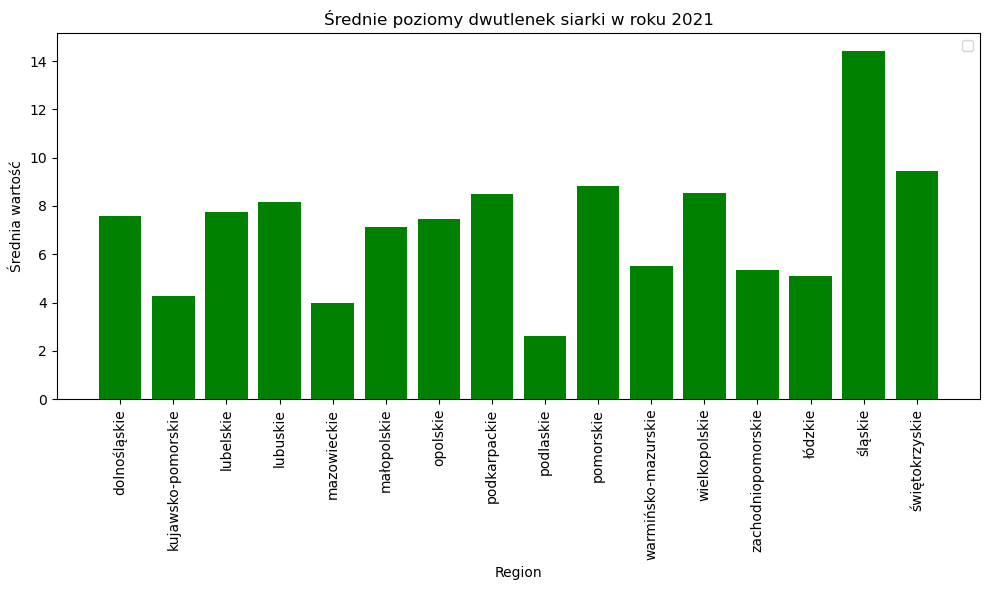

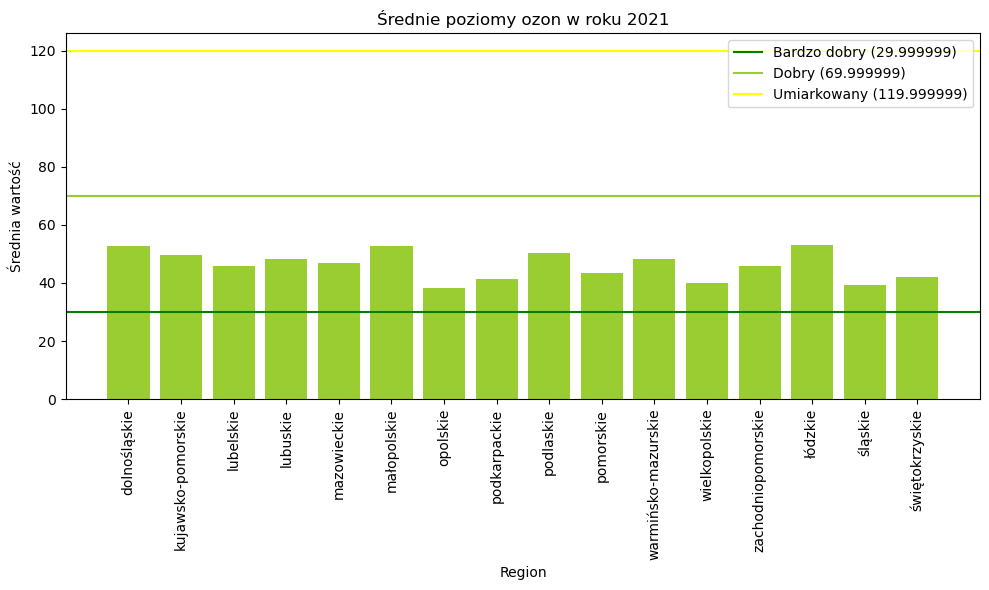

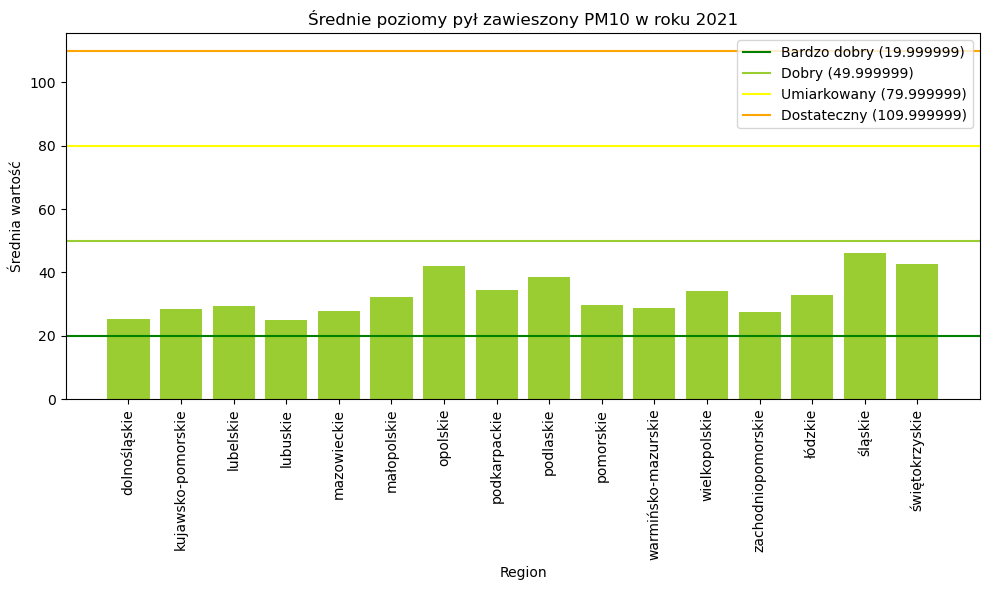

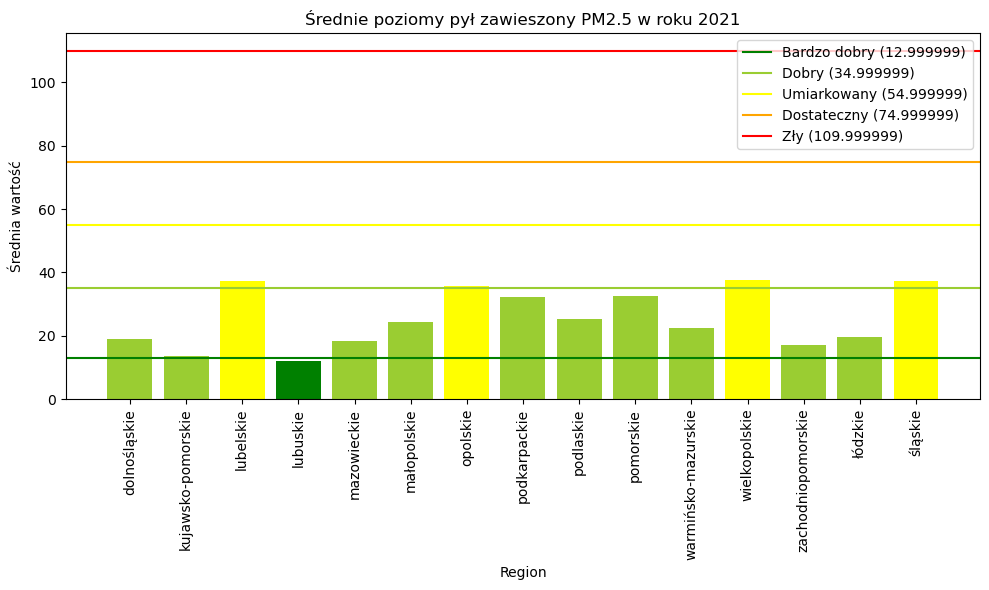

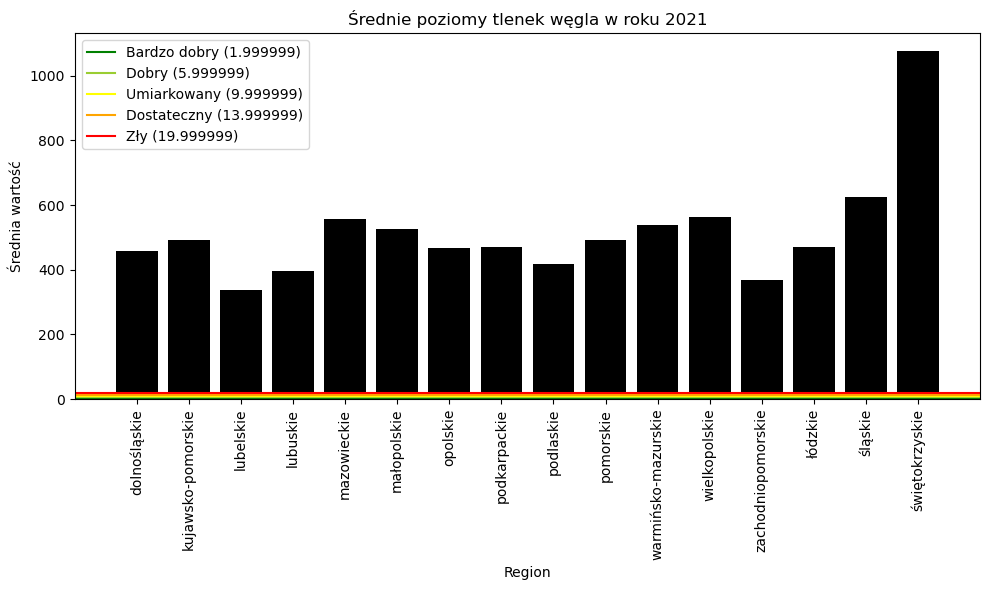

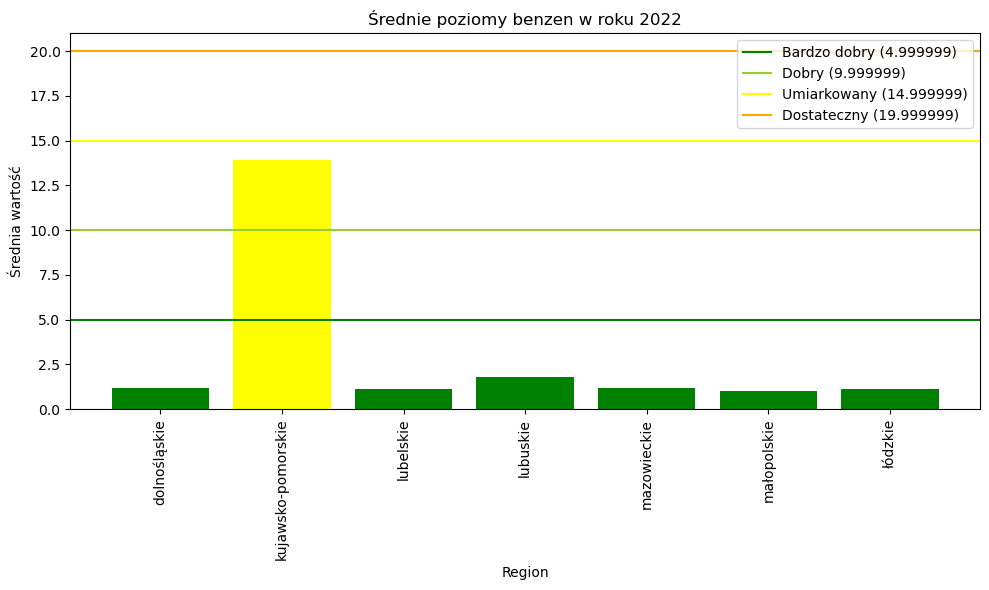

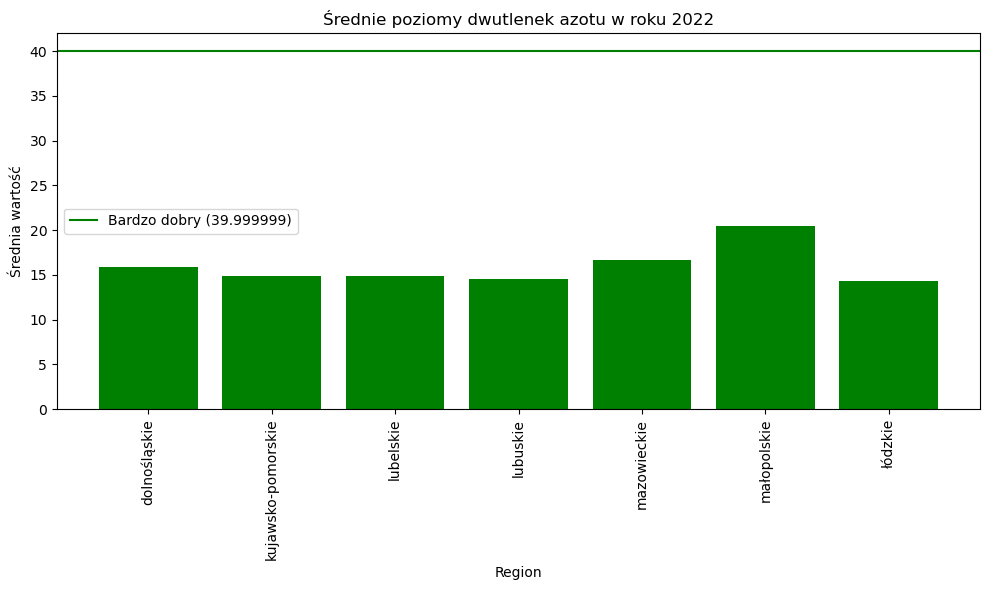

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


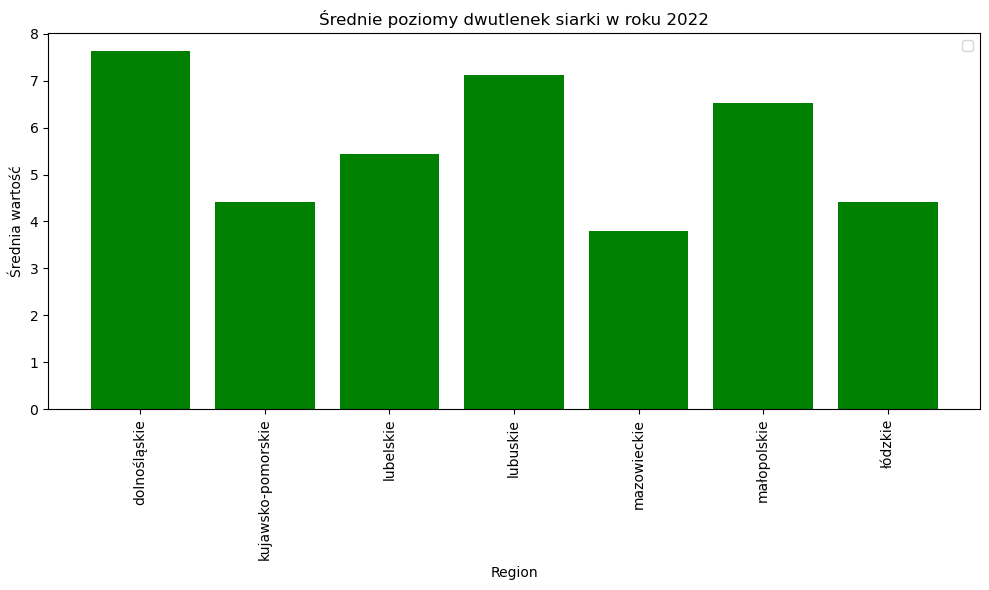

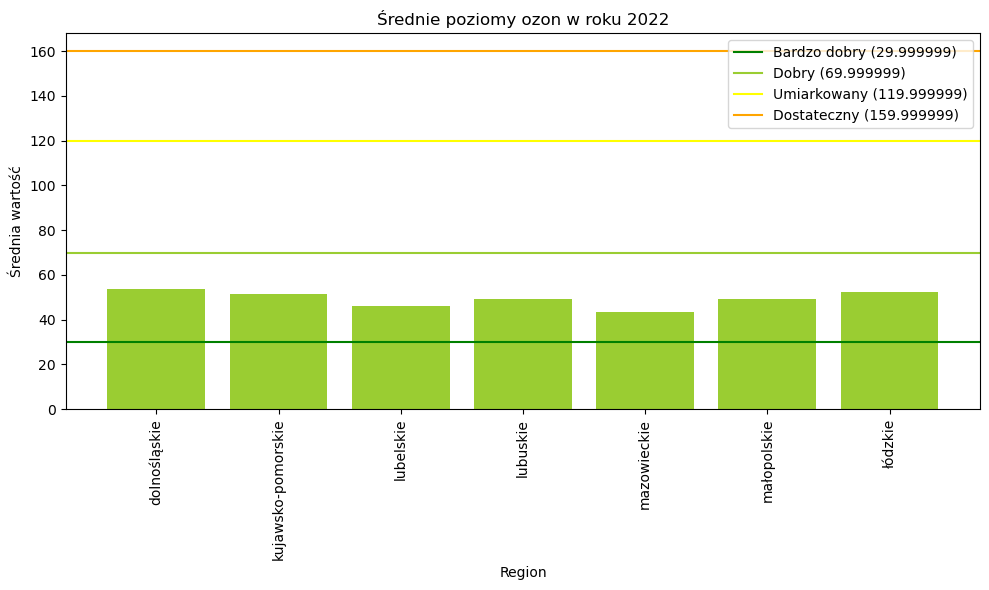

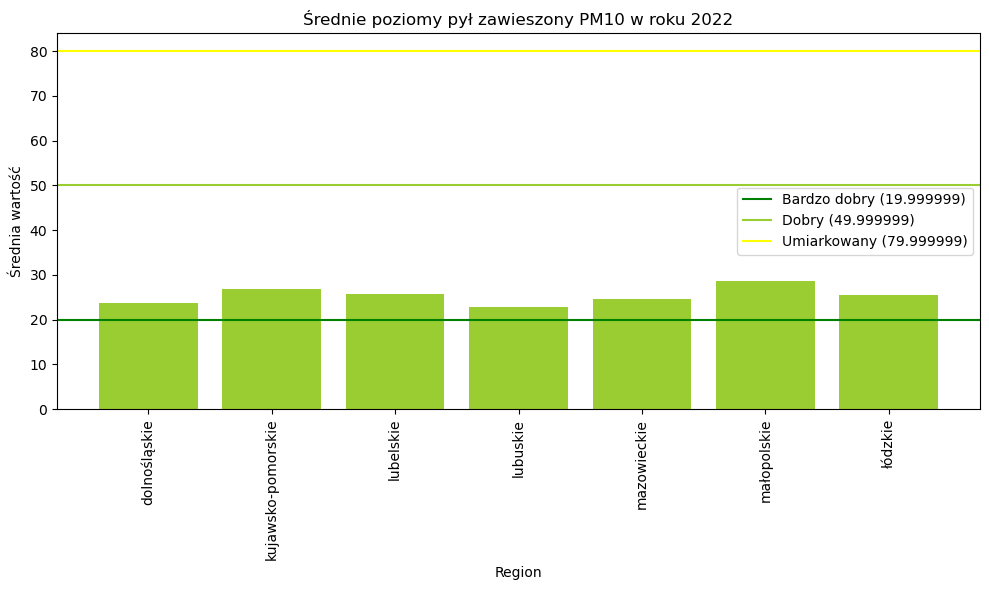

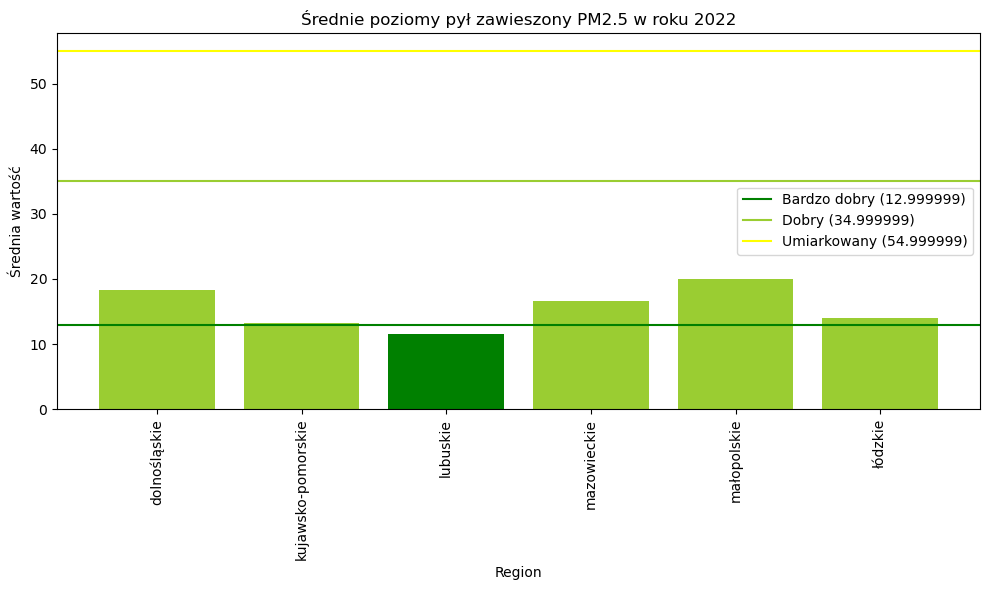

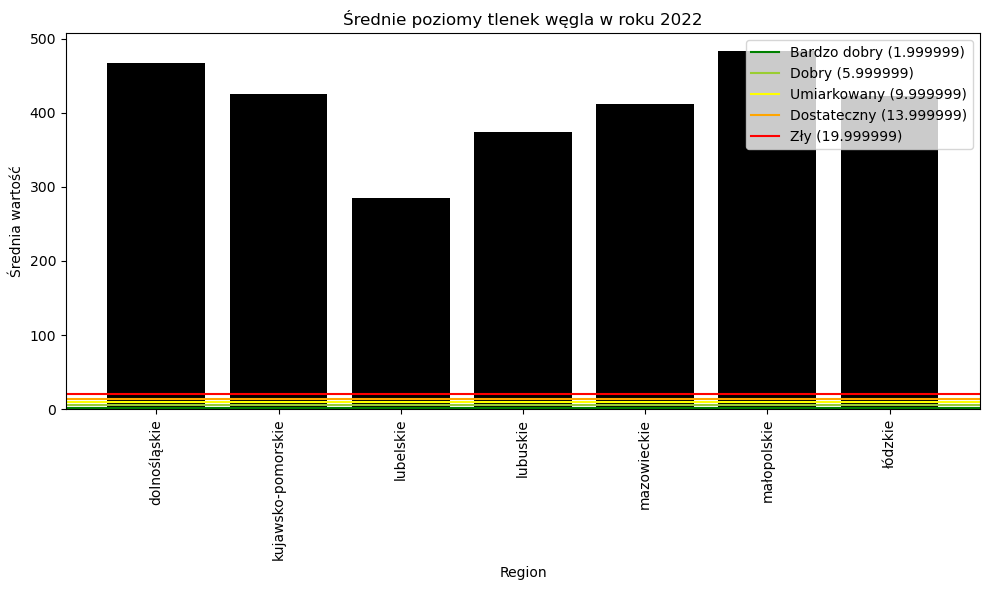

In [3]:
normy_query = "SELECT Wskaznik, Poziom, od, do FROM Normy;"
normy_data = pd.read_sql_query(normy_query, engine)
mapowanie_nazw = {
    'SO2': 'dwutlenek siarki',
    'CO': 'tlenek węgla',
    'O3': 'ozon',
    'PM10': 'pył zawieszony PM10',
    'PM25': 'pył zawieszony PM2.5',
    'NO2': 'dwutlenek azotu',
    'C6H6': 'benzen',
}
kolory_poziomow = {
    'Bardzo dobry': 'green',
    'Dobry': 'yellowgreen',
    'Umiarkowany': 'yellow',
    'Dostateczny': 'orange',
    'Zły': 'red',
    'Bardzo zły': 'black'
}
normy_dict = {}
for index, row in normy_data.iterrows():
    wskaźnik = mapowanie_nazw.get(row['Wskaznik'], row['Wskaznik'])  # Mapowanie na pełne nazwy
    if wskaźnik not in normy_dict:
        normy_dict[wskaźnik] = {}
    normy_dict[wskaźnik][row['Poziom']] = row['do']
    
def visualize_data(data, year, norms, kolory_poziomow, max_scale_factor=3):
    grouped_data = data.groupby(['Parameter', 'Region']).apply(lambda x: x[['Value']].mean()).reset_index()

    for parameter in grouped_data['Parameter'].unique():
        parameter_data = grouped_data[grouped_data['Parameter'] == parameter]
        max_value = parameter_data['Value'].max()

        plt.figure(figsize=(10, 6))
        plt.title(f'Średnie poziomy {parameter} w roku {year}')

        for i, row in parameter_data.iterrows():
            color = 'grey'  # Domyślny kolor
            for level, norm_value in norms[parameter].items():
                if row['Value'] <= norm_value:
                    color = kolory_poziomow[level]
                    break
            plt.bar(row['Region'], row['Value'], color=color)

        if parameter in norms:
            for level, norm_value in norms[parameter].items():
                if norm_value <= max_value * max_scale_factor:
                    plt.axhline(y=norm_value, label=f'{level} ({norm_value})', linestyle='-', color=kolory_poziomow[level])

        plt.xlabel('Region')
        plt.ylabel('Średnia wartość')
        plt.xticks(rotation=90)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Przykładowe wywołanie funkcji
for year in range(2021, 2023):
    yearly_data = air_polution[air_polution['Year'] == year]
    visualize_data(yearly_data, year, normy_dict, kolory_poziomow)